In [1]:
import os
import errno

import numpy as np

import deepcell

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6480, 216, 256, 1)
y.shape: (6480, 216, 256, 1)


In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'mrcnn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 3  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

num_classes = 1  # "object" is the only class

In [6]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))

In [7]:
from deepcell import model_zoo

model = model_zoo.RetinaMask(
    backbone=backbone,
    input_shape=X_train.shape[1:],
    class_specific_filter=False,
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params
)

prediction_model = model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
from deepcell.training import train_model_retinanet

model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=DATA_FILE,  # full path to npz file
    model_name=model_name,
    sigma=3.0,
    alpha=0.25,
    gamma=2.0,
    include_masks=True,  # include mask generation
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params,
    test_size=test_size,
    seed=seed,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6480, 216, 256, 1)
y_train shape: (6480, 216, 256, 1)
X_test shape: (720, 216, 256, 1)
y_test shape: (720, 216, 256, 1)
Output Shape: (None, 100, None)
Number of Classes: None
Training on 1 GPUs
Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 80/726 [==>...........................] - ETA: 4:38 - loss: 1.5590 - regression_loss: 1.1385 - classification_loss: 0.1738 - masks_loss: 0.2467
Epoch 00001: val_loss improved from inf to 1.55900, saving model to /data/models/mrcnn_model.h5
4915 instances of class 0 with average precision: 0.8539

mAP: 0.8539
726/726 [==============================] - 452s 622ms/step - loss: 2.3881 - regression_loss: 1.7243 - classification_loss: 0.3447 - masks_loss: 0.3191 - val_loss: 1.5590 - val_regression_loss: 1.1385 - val_classification_loss: 0.1738 - val_masks_loss: 0.2467
Epoch 2/3
 80/726 [==>...........................] - ETA: 4:39 - loss: 1.3467 - regression_loss: 0.9839 - classification_loss: 0.1304 - masks_loss: 0.2324
Epoch 00002: val_loss improved from 1.55900 to 1.34673, saving model to /data/models/mrcnn_model.h5
4915 instances of class 0 with average precision: 0.8847
mAP: 0.8847
726/726 [==============================] - 419s 577ms/step - loss: 1.5446 - regression_loss: 1.1127 - clas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 476


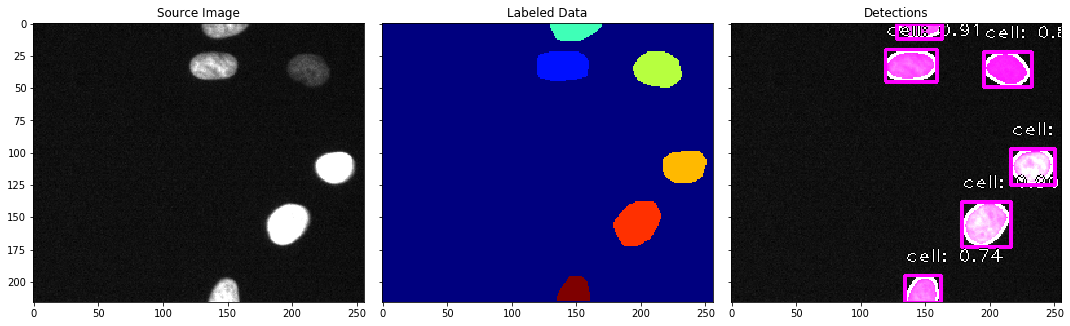

In [9]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

boxes, scores, labels, masks = prediction_model.predict(image)[-4:]

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

# copies to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0],
           score_threshold=0.5)

# draw the detections
draw_detections(draw, boxes[0], scores[0], labels[0],
                label_to_name=lambda x: 'cell',
                score_threshold=0.5,)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Labeled Data')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

fig.tight_layout()
plt.show()